In [1]:
from utils.binaries import *
from utils.plotting import *
from itertools import product

16:08:41 [INFO] utils          -- (+10448ms) -- import logging
16:08:41 [INFO] utils.binaries -- (   +96ms) -- import numpy as np
16:08:41 [INFO] utils.binaries -- (    +9ms) -- import uncertainties
16:08:42 [INFO] utils.binaries -- (  +170ms) -- import pandas as pd
16:08:42 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
16:08:42 [INFO] utils.plotting -- (  +300ms) -- import matplotlib.pyplot as plt
16:08:42 [INFO] utils.plotting -- (  +354ms) -- import seaborn as so
16:08:42 [DBUG] utils.plotting -- (    +7ms) -- font size set to 9.5
16:08:42 [DBUG] utils.plotting -- (    +0ms) -- label size set to 13.0
16:08:42 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
16:08:42 [DBUG] utils.plotting -- (    +0ms) -- markersize set to 2.0
16:08:42 [DBUG] utils.plotting -- (    +0ms) -- usetex set to False
16:08:42 [INFO] utils.plotting -- (    +2ms) -- import plotting.tools as plot


In [23]:
def gradient(x, y):
    return x**2 + (100*y)**2

def read(station):

    multiplicities = range(2, 14)
    threshold = np.linspace(0.01, .25, 25)
    all_params = list(product(multiplicities, threshold))

    base = '/cr/users/filip/Data/totRateMap/'
    data = np.loadtxt(f'{base}/{station}.txt')
    container = np.empty((4, len(all_params)))
    container[:] = np.nan
    x, y, z1, z2 = container

    for row in data:
        x_, y_, z_tot, z_totd, t = row
        # print(x_, y_, z_tot, z_totd, t)

        for this_index, (_x, _y) in enumerate(all_params):
            if _x == x_ and _y == y_: break

        x[this_index] = x_
        y[this_index] = y_
        z1[this_index] = z_tot
        z2[this_index] = z_totd

    assert len(DAQ_seconds := np.unique(data[:, 4])) == 1, f"DAQ time(s) do not match: {DAQ_seconds = }"

    return x, y, z1, z2, *DAQ_seconds

def visualize(data, l=None):

    multiplicities = range(2, 14)
    threshold = np.linspace(0.01, .25, 25)

    x, y, z1, z2, time = data
    z1 = z1.reshape((len(multiplicities), len(threshold))) / time
    z2 = z2.reshape((len(multiplicities), len(threshold))) / time
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

    for ax, z, trigger in zip(axes, [z1, z2], ['ToT', 'ToTd']):

        ax.set_box_aspect(1)
        image = ax.imshow(z.T, extent=(2, 14, 0, .25), 
                          aspect='auto', 
                          cmap='viridis', 
                          origin='lower',
                          interpolation='none',
                          norm='log',
                          vmin=0.1, vmax=200)
        if l is not None:
            levels = ax.contour(z.T, levels=l, 
                                extent=(2, 14, 0, .25), 
                                origin='lower', 
                                alpha=0.9, 
                                colors='k',
                                vmin=0, vmax=150,)
            ax.clabel(levels, colors='k', fontsize=9, inline=True, inline_spacing=40, fmt='%i Hz')

        ax.set_ylabel('threshold / nominal')
        ax.set_xlabel('occupancy / bins')

        ax.annotate('current', (13, 0.2), (13, 0.21), horizontalalignment='right')
        ax.scatter(13, 0.2, marker='x', s=10)

        ax.set_title(f'{trigger}, {time:.1f} s of DAQ')
        plt.colorbar(image, label='rate / Hz', shrink=0.74)
        ax.minorticks_off()

        ax.set_xlim(3)

    yticks = np.arange(0, 0.241, 0.02)
    _ = ax.set_yticks(yticks[::2], [f"{x/0.2:.1f}" for x in yticks[::2]])

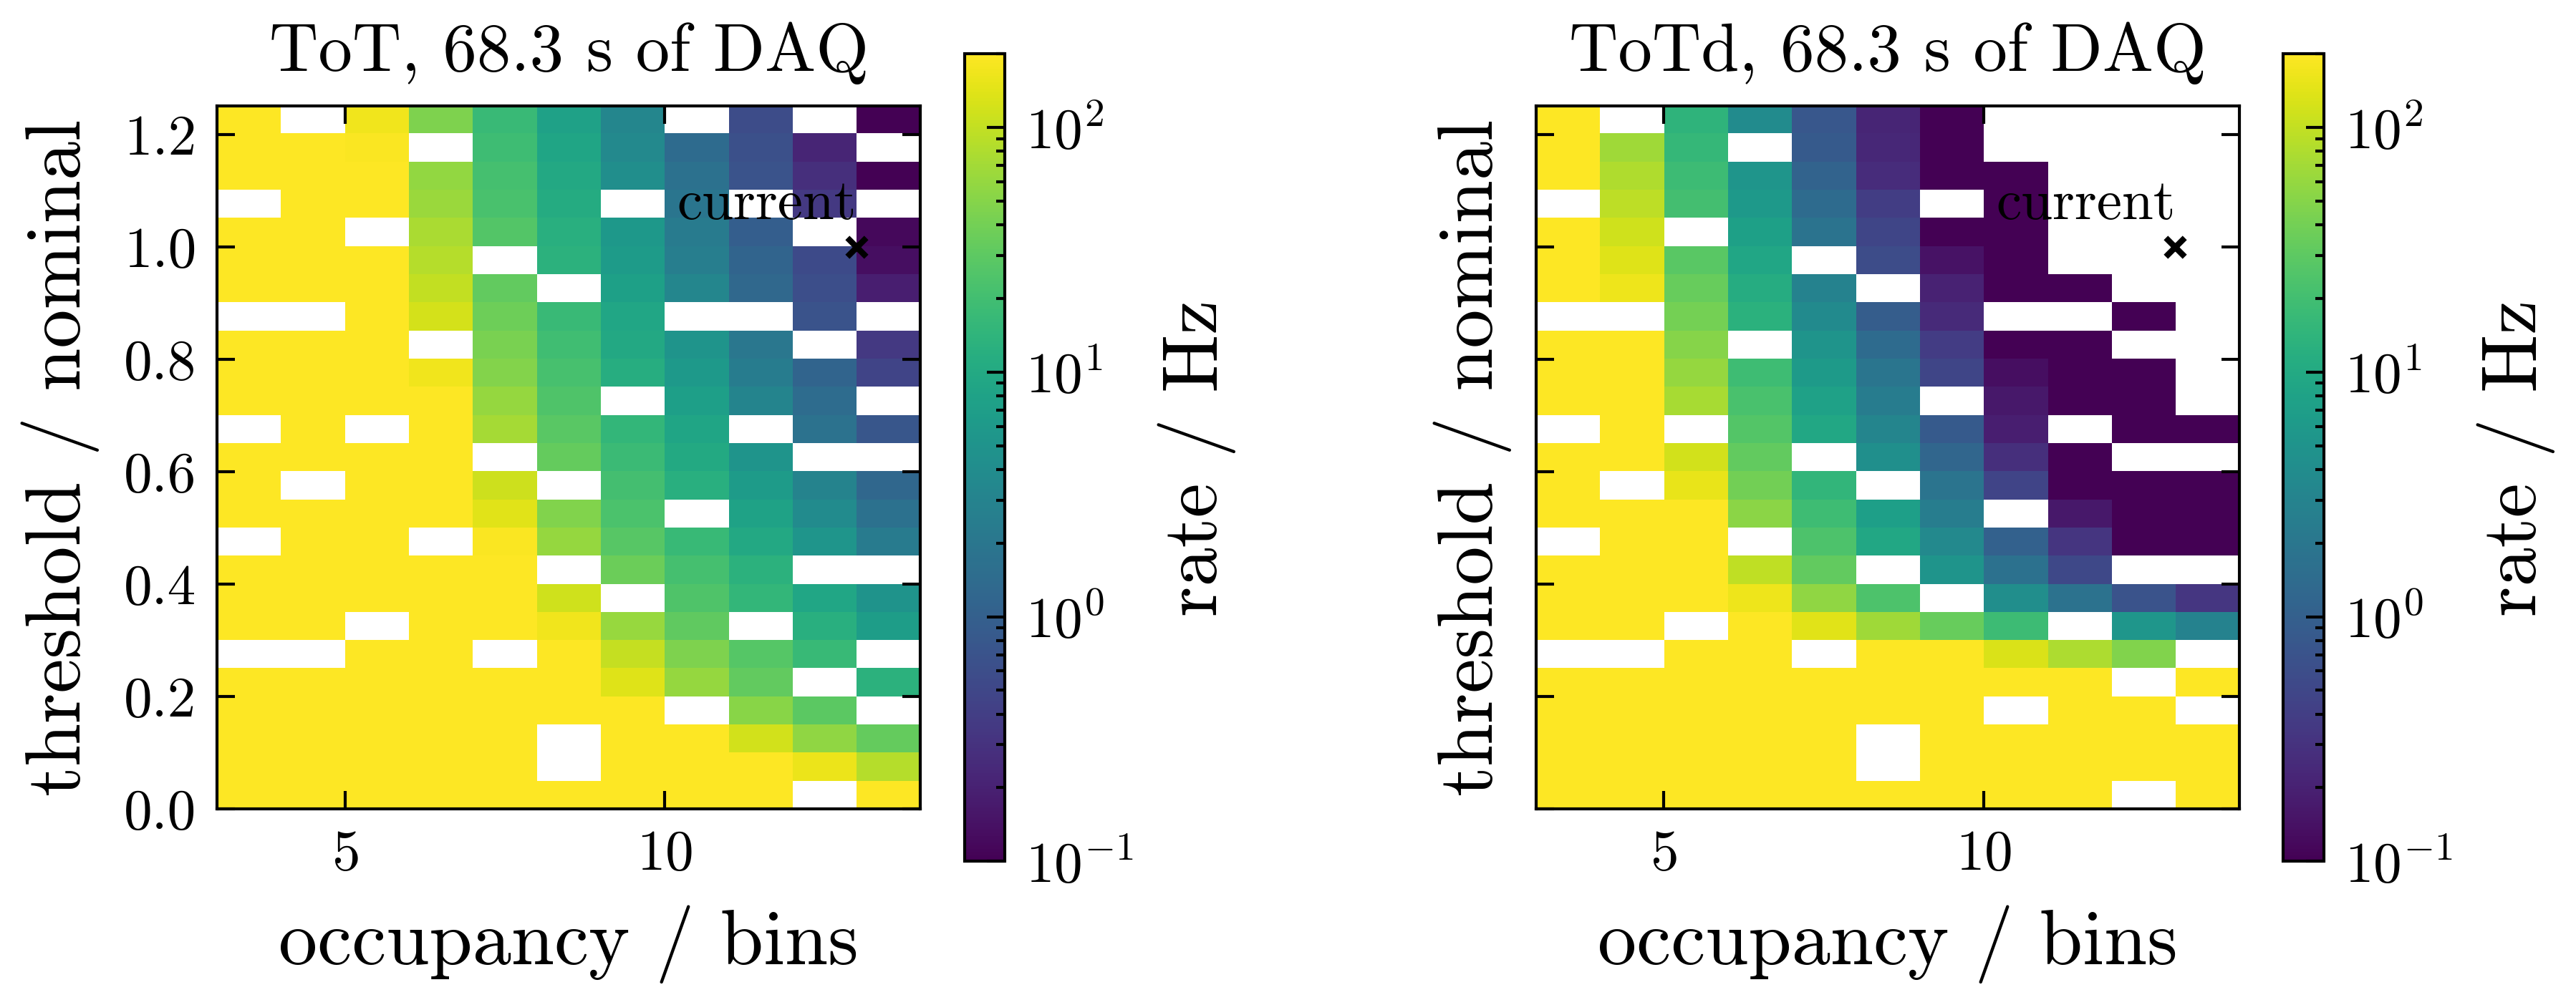

In [24]:
data_nadia = read('Nadia')
visualize(data_nadia)
plt.subplots_adjust(wspace=0.5)

plt.savefig('/cr/users/filip/plots/UubRandoms/tot_rate_maps/Nadia_FDS.png')

# bins, threshold, ntot, ntotd, time = np.loadtxt('/cr/users/filip/Data/totRateMap/Nadia.txt', unpack=True)
# plt.gca().scatter(bins, threshold, c=np.log(ntotd), cmap='Reds', s=120, alpha=1, marker='s')